In [89]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [90]:
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Loads GRIB data from the specified file, extracts relevant columns (longitude, latitude, msl),
    and returns the data as a pandas DataFrame.
    """
    ds = xr.open_dataset(file_path, engine='cfgrib')
    df = ds['msl'].to_dataframe().reset_index()[['longitude', 'latitude', 'msl']]
    return df

def split_data(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Splits the DataFrame into train and test sets (90:10), converts them to numpy arrays, 
    and returns the split data.
    """
    train, test = train_test_split(df, test_size=0.1, random_state=42)
    return train.to_numpy(), test.to_numpy()

In [91]:
def generate_sparse_jl_matrix(n: int, k: int) -> np.ndarray:
    """
    Generates a sparse random projection matrix of size (k, n) using the JL lemma. 
    The matrix elements are either +sqrt(3/k), -sqrt(3/k), or 0 based on random probability.

    Parameters:
        n (int): Number of columns in the projection matrix.
        k (int): Number of rows in the projection matrix.

    Returns:
        np.ndarray: A (k, n) sparse random projection matrix.
    """
    value = np.sqrt(3 / k)
    M = np.zeros((k, n), dtype=np.float32)
    random_vals = np.random.rand(k, n)
    M[random_vals < 1/6] = value
    M[(random_vals >= 1/6) & (random_vals < 1/3)] = -value
    return M

In [92]:
from typing import Tuple
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_model_with_scaling(
    train: np.ndarray,
    test: np.ndarray,
    scale_matrices_x: np.ndarray,
    scale_matrices_y: np.ndarray,
    ml_model,
) -> Tuple[float, np.ndarray]:
    """
    Trains the given ML model on original data, then evaluates it on scaled data using 
    multiple Sparse JL matrices. Computes the MSE for both original and scaled data, 
    and returns the losses.

    Parameters:
        train (np.ndarray): Training data array of shape (n_samples, 3).
        test (np.ndarray): Testing data array of shape (n_samples, 3).
        scale_matrices_x (np.ndarray): Array of sparse JL matrices for scaling the train data.
        scale_matrices_y (np.ndarray): Array of sparse JL matrices for scaling the test data.
        ml_model: An instance of a scikit-learn model.

    Returns:
        Tuple[float, np.ndarray]: Original data loss and an array of scaled losses.
    """
    X_train, y_train = train[:, :2], train[:, 2]
    X_test, y_test = test[:, :2], test[:, 2]

    # Train on original data
    ml_model.fit(X_train, y_train)
    original_loss = mean_squared_error(y_test, ml_model.predict(X_test))

    print("Evaluated original data")

    # Initialize list to store scaled losses
    scaled_losses = []

    # Evaluate the model on scaled data for each scale matrix
    for (i, (scale_matrix_x, scale_matrix_y)) in enumerate(zip(scale_matrices_x, scale_matrices_y)):
        scaled_train = scale_matrix_x @ X_train
        scaled_y_train = scale_matrix_y @ y_train
        ml_model.fit(scaled_train, scaled_y_train)
        scaled_losses.append(mean_squared_error(y_test, ml_model.predict(X_test)))
        print(f"Evaluated scaled down data {i}")
        print(f"Experiment {i+1}: Original loss: {original_loss} Scaled loss: {scaled_losses[-1]}")

    return original_loss, np.array(scaled_losses)

In [93]:
NUM_EXPERIMENTS = 5

def run_experiments(train: np.ndarray, test: np.ndarray) -> None:
    """
    Runs experiments with different ML models, comparing their performance on original and 
    scaled data using Sparse JL matrix, and plots the results.

    Parameters:
        train (np.ndarray): Training data array of shape (n_samples, 3).
        test (np.ndarray): Testing data array of shape (n_samples, 3).
    """
    models = [
        #("Random Forest", RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)),
        ("LinearRegression", LinearRegression()),
    ]
    results = {}

    d = train.shape[1] - 1   # 2 features

    for model_name, model in models:
        # Generate 5 random Sparse JL matrices
        scale_matrices_train = [generate_sparse_jl_matrix(n=len(train), k=10*d) for _ in range(NUM_EXPERIMENTS)]
        scale_matrices_test = [generate_sparse_jl_matrix(n=len(train), k=10*d) for _ in range(NUM_EXPERIMENTS)]
        
        # Run the evaluation
        orig_loss, scaled_losses = evaluate_model_with_scaling(train, test, scale_matrices_train,
                                                               scale_matrices_test, model)
        
        # Store the results
        results[model_name] = (orig_loss, scaled_losses)

    # Plot the results
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(NUM_EXPERIMENTS)

    x = np.arange(NUM_EXPERIMENTS)

    # Plot the original loss bars (blue)
    plt.bar(x - bar_width / 2, [orig_loss] * NUM_EXPERIMENTS, color='b', width=bar_width, label='Original Loss')

    # Plot the scaled loss bars (red)
    plt.bar(x + bar_width / 2, scaled_losses, color='r', width=bar_width, label='Scaled Loss')

    # Add text labels on top of each original loss bar
    for i in range(NUM_EXPERIMENTS):
        plt.text(i - bar_width / 2, orig_loss, f"{orig_loss:.2f}", ha='center', va='bottom')

    # Add text labels on top of each bar
    for i, loss in enumerate(scaled_losses):
        plt.text(i + bar_width / 2, loss, f"{loss:.2f}", ha='center', va='bottom')

    # Set the labels and title
    plt.xticks(x, [f"Exp {i+1}" for i in range(NUM_EXPERIMENTS)])
    plt.ylabel("Mean Squared Error")
    plt.title("Original Loss vs Scaled Loss Comparison (Multiple Experiments)")

    # Add the legend
    plt.legend()

    # Show the plot
    plt.show()


Evaluated original data
Evaluated scaled down data 0
Experiment 1: Original loss: 1303453.9486850344 Scaled loss: 465283215821.64185
Evaluated scaled down data 1
Experiment 2: Original loss: 1303453.9486850344 Scaled loss: 38126960624359.52
Evaluated scaled down data 2
Experiment 3: Original loss: 1303453.9486850344 Scaled loss: 9406731795668.832
Evaluated scaled down data 3
Experiment 4: Original loss: 1303453.9486850344 Scaled loss: 27046121575946.535
Evaluated scaled down data 4
Experiment 5: Original loss: 1303453.9486850344 Scaled loss: 45969180474975.58


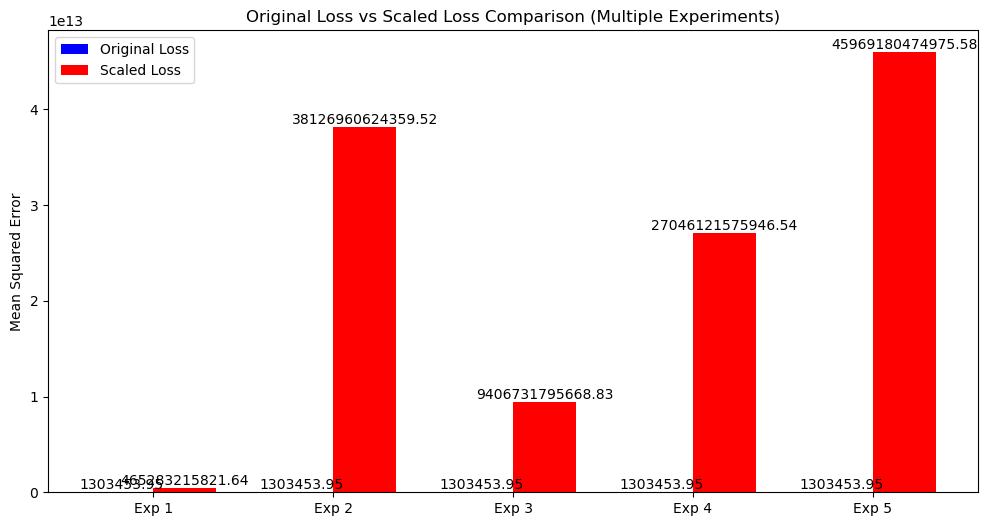

In [95]:
# Main script execution
file_path = 'MSLP_dataset.grib'  # Specify the path to your GRIB file
df = load_and_preprocess_data(file_path)
train_data, test_data = split_data(df)
run_experiments(train_data, test_data)